# Introduction

Continual learning for semantic segmentation is a field that has emerged recently and is quickly evolving. As a newcomer to the field, I wanted to quickly get in touched with the popular approaches and see by myself some concrete results. However, if one wants to rerun the experiments made in recent papers, which often use medium- to large-scale datasets such as Pascal-VOC, ADE20K or COCO, it would require several hours of training. 

Therefore, I took inspiration from the [Simple Deep Learning project](https://https://awaywithideas.com/mnist-extended-a-dataset-for-semantic-segmentation-and-object-detection/) by Luke Tonin in which he built MNIST-Extended, a semantic segmentation dataset  made from MNIST. While this is obviously a toy dataset, it has the benefit of giving quick feedback while tinkering with models. 

I adapted it to the class-incremental scenario such that the segmentation masks are only available for the current classes. Learning the 0-9 digits is therefore performed in successive tasks. In this tutorial, we explore a scenario in which there are 2 new classes to learn at each task: (0, 1), (2, 3), (4, 5), (6, 7), (8, 9). 

This will also enable to explore common challenges of continual semantic segmentation such as Catastrophic forgetting, background shift, and the various combinations of setups where past/future classes are/are not in images and labeled as background. 

# TODO
1. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
# some initial imports
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import sys
from tqdm import tqdm
import pandas as pd

os.chdir("/content/gdrive/MyDrive/Colab Notebooks/mnist_continual_seg")
sys.path.append("/content/gdrive/MyDrive/Colab Notebooks/simple_deep_learning")

Now that the segmentation dataset is loaded, we need to adapt it to reflect the continual setup where classes are seen sequentially. To do so, we will implement a processing function that only keeps the groundtruth masks for the current learning step. For instance, if we divide the 10 classes from MNIST in 5 learning steps of 2 classes, then at step #0 the model is only trained to segment digits 0 and 1, while other digits on the image are labeled as background (i.e. label '0'). Then, at step #1 where the model must learn to segment 2's and 3's, digits 0-1 and 4-9 will be labeled as background, and so on.

This scenario reflects the common experimental setup in which segmentation masks are only available for current classes while objects that belong to past and future classes can still appear in scene images (e.g. from Pascal-VOC) but are labeled as background. This is a challenge specific to Continual Semantic Segmentation known as Background shift, which is addressed in several recent works (MiB, PLOP, SSUL, RECALL, etc). 

In [2]:
from trainer import Trainer, Trainer_MIB, Trainer_distillation
from metrics import EvaluaterCallback
from scenarios import ContinualMnist
from models import simple_seg_model
from utils import meta_train
_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}

In [3]:
from models.backbones import simple_backbone
from models.modules import self_attention_cam

In [4]:
#!git clone https://github.com/frgfm/torch-cam.git
#!pip install -e torch-cam/. --upgrade

In [5]:
from torchcam.cams import CAM


In [6]:
class PseudoSeg(simple_seg_model):
  def __init__(self,
               conv_filters=32,
               n_classes_per_task=[2],
               input_shape=(1, 60,60),
               attention_dim=32):

    super(PseudoSeg, self).__init__(conv_filters,
                                    n_classes_per_task,
                                    input_shape)
    
    self.cam = nn.Sequential(nn.Conv2d(conv_filters , conv_filters, kernel_size=3, padding=1, bias=False),
                             nn.BatchNorm2d(conv_filters),
                             nn.ReLU(),
                             nn.Conv2d(conv_filters , conv_filters, kernel_size=1, bias=False),
                             nn.BatchNorm2d(conv_filters),
                             nn.ReLU()
                             )
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.classif = nn.Conv2d(self.conv_filters, sum(n_classes_per_task), 1) 
    self.sa = self_attention_cam(num_class=sum(n_classes_per_task),
                                 in_dim=conv_filters,
                                 attention_dim=attention_dim)
    
  def forward(self, x):
    x_enc = self.encoder(x)
    cam, y_labs = self._classification_head(x_enc) # (b, c, 1, 1)

    #self_attn = self.sa(x_enc.detach().clone()) # stop gradient

    x_dec = self.decoder(x_enc)
    y_seg = self._segmentation_head(x_dec)

    return cam, y_labs, y_seg#, self_attn

  def self_attention(self, logits, features):
    x = self.sa(logits, features)
    return x

    
  def _classification_head(self, x):
    cam = self.cam(x)
    avg = self.avg_pool(cam)
    
    cls = self.classif(avg).squeeze(-1).squeeze(-1)
    return cam, cls

  def _segmentation_head(self, x):
    x_o = self.cls(x)
    return x_o


In [35]:
def _div_maybe_zero(total_loss, num_present):
  """Normalizes the total loss with the number of present pixels."""
  return (num_present > 0).float() * total_loss/torch.max(num_present, torch.ones_like(num_present)*1e-5)

def compute_cam(features, logits, num_class, image_labels):
  conv_layer = features

  cams = []
  for c in range(num_class-1):
    grads = torch.autograd.grad(torch.sum(logits[:, c+1]), conv_layer, retain_graph=True)
    weights = torch.mean(grads[0], axis=(2,3), keepdim=True)
    weighted_grads = weights * conv_layer
    curr_cams = F.relu(torch.sum(weighted_grads, axis=1))
    cams.append(curr_cams)
  cams = torch.stack(cams, axis=1)

  # image-level annotation
  cls_label = torch.reshape(image_labels[:,1:], [-1, num_class - 1, 1, 1])
  cams = cls_label * cams

  # Normalize to [0, 1])
  cams = _div_maybe_zero(cams, torch.amax(cams, dim=(2,3), keepdim=True))

  #stop gradient
  out_cam = cams#.detach().clone()

  return out_cam

class Trainer_PseudoSeg(Trainer):
  def __init__(self,
               model,
               n_classes,
               optim,
               curr_task=0,
               callbacks=[],
               layers_name=None,
               show_preds = False,
               **kwargs):
    super(Trainer_PseudoSeg, self).__init__(model,
                                            n_classes,
                                            optim,
                                            curr_task,
                                            callbacks,
                                            layers_name,
                                            **kwargs)
    self.show_preds = show_preds
  def train(self, 
            cur_epoch,
            scenario,
            memory=None,
            sample_memory=False):
    """Train for 1 epoch."""
    epoch_loss = 0
    num_classes = sum(self.n_classes_per_task)
    if cur_epoch > 500:
        self.show_preds=True
    for cur_step, (images, labels, image_labels) in enumerate(scenario.train_stream):      
      if self.show_preds:
        plt.imshow(images[0].detach().cpu().numpy()[0])
        plt.show()
      images, labels, image_labels = images.cuda().float(), labels.cuda().long(), image_labels[:, :num_classes].cuda()
      epoch_loss += self._train_step(images, labels, image_labels)
      self._apply_callbacks(scenario, freq="step")
    self._apply_callbacks(scenario, freq="epoch")
    return epoch_loss / len(scenario.train_stream)


  def sharpen(self, p, m, T):
    def _norm(a, b):
      return F.normalize(a+b)
    norm = _norm(p, m)
    p_hat = F.softmax(p / norm, dim=1)
    m_hat = F.softmax(m / norm, dim=1)

    x = 0.5 * p_hat + 0.5 * m_hat
    return x

  def _train_step(self, images, labels, image_labels):
    """Perform 1 training iteration."""
    num_classes = sum(self.n_classes_per_task)
    self.optim.zero_grad()
    features, y_labs, y_seg = self.model(images)

    activation_map = compute_cam(features, y_labs, y_labs.shape[1], image_labels)
    out_att_cam = self.model.self_attention(activation_map, features)#self.model.self_attention(activation_map.detach().clone(), features.detach().clone()) #
    att_logits_weak = F.interpolate(out_att_cam, y_seg.shape[2:], mode="bilinear", align_corners=True)
    att_prob_weak = F.softmax(att_logits_weak, dim=1)

    # Add bg score
    bg = 1 - torch.max(activation_map, dim=1, keepdims=True)[0]
    activation_map = torch.cat([bg, activation_map], dim=1)
    
    y_one_hot = F.one_hot(labels, num_classes = num_classes).permute(0,3,1,2)

    #if self.show_preds:
    y_hat_semi = att_prob_weak#self.sharpen(y_seg, att_logits_weak, 1)
    y_hat_semi = torch.max(y_hat_semi, dim=1)[1].long()
    y_hat_semi[labels!=0] = labels[labels!=0]

    print(torch.unique(y_hat_semi))

    if self.show_preds:
      plt.imshow(np.argmax(activation_map[0].detach().cpu().numpy(), axis=0))
      plt.show()
      plt.imshow(np.argmax(out_att_cam[0].detach().cpu().numpy(), axis=0), vmin=0, vmax=2)
      plt.show()
      plt.imshow(np.argmax(att_logits_weak[0].detach().cpu().numpy(), axis=0), vmin=0, vmax=2)
      plt.show()
      plt.imshow(np.argmax(y_seg[0].detach().cpu().numpy(), axis=0), vmin=0, vmax=2)
      plt.show()
    #bg = 1 - torch.amax(activation_map, dim=1, keepdim=True)
    #activation_map = torch.cat([bg, out_att_cam])

    #TODO un_loss = self._compute_un_loss(images)
    classif_loss = self._compute_classif_loss(y_labs[:,1:num_classes], image_labels.float()[:,1:num_classes])
    seg_loss = self._compute_seg_loss(y_seg, y_hat_semi)
    attn_loss = self._compute_seg_loss(att_logits_weak, labels)
    loss = classif_loss + attn_loss + seg_loss
    #loss = self._compute_loss(outputs, labels)

    loss.backward()

    self.optim.step()
    return loss

  def _compute_seg_loss(self, y_pred, labels):
    return self._compute_loss(y_pred, labels)

  def _compute_classif_loss(self, y_pred, y_true):
    #print(y_pred, y_true)
    return nn.BCEWithLogitsLoss()(y_pred, y_true)

  def _compute_un_loss(self, images, labels):
    pass


In [36]:
from trainer import Trainer_PseudoLabel_ImageLabels
# Initialize dataloader, optimizer and trainer
#### Il va falloir distiller dans le self attention pour empêcher le forgetting
model = PseudoSeg(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=1000, n_test=1000, batch_size=72, tasks=_tasks, return_im_level_label=True)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="task", n_classes=11, save_matrices=True, out_idx=2)

trainer = Trainer_PseudoSeg(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  callbacks=[evaluater],
                  layers_name=["classif.weight",
                               "classif.bias",
                               "cls.weight",
                               "cls.bias"],
                  show_preds=False)

meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="nothing_yet")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


  0%|          | 0/200 [00:00<?, ?it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  1%|          | 2/200 [00:00<00:39,  4.95it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  2%|▏         | 3/200 [00:00<00:38,  5.05it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  2%|▏         | 4/200 [00:00<00:38,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  2%|▎         | 5/200 [00:00<00:38,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  3%|▎         | 6/200 [00:01<00:37,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  4%|▎         | 7/200 [00:01<00:37,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  4%|▍         | 8/200 [00:01<00:37,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  5%|▌         | 10/200 [00:01<00:37,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  6%|▌         | 11/200 [00:02<00:36,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  6%|▌         | 12/200 [00:02<00:36,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  6%|▋         | 13/200 [00:02<00:36,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  7%|▋         | 14/200 [00:02<00:36,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  8%|▊         | 15/200 [00:02<00:36,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  8%|▊         | 16/200 [00:03<00:36,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


  9%|▉         | 18/200 [00:03<00:35,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 10%|▉         | 19/200 [00:03<00:35,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 10%|█         | 20/200 [00:03<00:35,  5.04it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 10%|█         | 21/200 [00:04<00:35,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 11%|█         | 22/200 [00:04<00:34,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 12%|█▏        | 23/200 [00:04<00:34,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 12%|█▏        | 24/200 [00:04<00:34,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 13%|█▎        | 26/200 [00:05<00:34,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 14%|█▎        | 27/200 [00:05<00:33,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 14%|█▍        | 28/200 [00:05<00:33,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 14%|█▍        | 29/200 [00:05<00:33,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 15%|█▌        | 30/200 [00:05<00:33,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 16%|█▌        | 31/200 [00:06<00:33,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 16%|█▌        | 32/200 [00:06<00:32,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 17%|█▋        | 34/200 [00:06<00:32,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 18%|█▊        | 35/200 [00:06<00:32,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 18%|█▊        | 36/200 [00:07<00:31,  5.15it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 18%|█▊        | 37/200 [00:07<00:31,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 19%|█▉        | 38/200 [00:07<00:31,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 20%|█▉        | 39/200 [00:07<00:31,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 20%|██        | 40/200 [00:07<00:31,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 21%|██        | 42/200 [00:08<00:30,  5.15it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 22%|██▏       | 43/200 [00:08<00:30,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 22%|██▏       | 44/200 [00:08<00:30,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 22%|██▎       | 45/200 [00:08<00:30,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 23%|██▎       | 46/200 [00:09<00:30,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 24%|██▎       | 47/200 [00:09<00:29,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 24%|██▍       | 48/200 [00:09<00:29,  5.15it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 25%|██▌       | 50/200 [00:09<00:29,  5.15it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 26%|██▌       | 51/200 [00:09<00:28,  5.15it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 26%|██▌       | 52/200 [00:10<00:28,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 26%|██▋       | 53/200 [00:10<00:28,  5.07it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 27%|██▋       | 54/200 [00:10<00:28,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 28%|██▊       | 55/200 [00:10<00:28,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 28%|██▊       | 56/200 [00:10<00:28,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 29%|██▉       | 58/200 [00:11<00:27,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 30%|██▉       | 59/200 [00:11<00:27,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 30%|███       | 60/200 [00:11<00:27,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 30%|███       | 61/200 [00:11<00:27,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 31%|███       | 62/200 [00:12<00:26,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 32%|███▏      | 63/200 [00:12<00:26,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 32%|███▏      | 64/200 [00:12<00:26,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 33%|███▎      | 66/200 [00:12<00:26,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 34%|███▎      | 67/200 [00:13<00:26,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 34%|███▍      | 68/200 [00:13<00:25,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 34%|███▍      | 69/200 [00:13<00:25,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 35%|███▌      | 70/200 [00:13<00:25,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 36%|███▌      | 71/200 [00:13<00:25,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 36%|███▌      | 72/200 [00:14<00:25,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 36%|███▋      | 73/200 [00:14<00:25,  5.02it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 38%|███▊      | 75/200 [00:14<00:24,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 38%|███▊      | 76/200 [00:14<00:24,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 38%|███▊      | 77/200 [00:15<00:24,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 39%|███▉      | 78/200 [00:15<00:23,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 40%|███▉      | 79/200 [00:15<00:23,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 40%|████      | 80/200 [00:15<00:23,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 40%|████      | 81/200 [00:15<00:23,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 42%|████▏     | 83/200 [00:16<00:23,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 42%|████▏     | 84/200 [00:16<00:23,  5.02it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 42%|████▎     | 85/200 [00:16<00:22,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 43%|████▎     | 86/200 [00:16<00:22,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 44%|████▎     | 87/200 [00:17<00:22,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 44%|████▍     | 88/200 [00:17<00:21,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 44%|████▍     | 89/200 [00:17<00:21,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 45%|████▌     | 90/200 [00:17<00:21,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 46%|████▌     | 92/200 [00:18<00:21,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 46%|████▋     | 93/200 [00:18<00:20,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 47%|████▋     | 94/200 [00:18<00:20,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 48%|████▊     | 95/200 [00:18<00:20,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 48%|████▊     | 96/200 [00:18<00:20,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 48%|████▊     | 97/200 [00:18<00:20,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 49%|████▉     | 98/200 [00:19<00:19,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 50%|█████     | 100/200 [00:19<00:19,  5.15it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 50%|█████     | 101/200 [00:19<00:19,  5.16it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 51%|█████     | 102/200 [00:19<00:19,  5.15it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 52%|█████▏    | 103/200 [00:20<00:18,  5.15it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 52%|█████▏    | 104/200 [00:20<00:18,  5.15it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 52%|█████▎    | 105/200 [00:20<00:18,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 53%|█████▎    | 106/200 [00:20<00:18,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 54%|█████▍    | 108/200 [00:21<00:17,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 55%|█████▍    | 109/200 [00:21<00:17,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 55%|█████▌    | 110/200 [00:21<00:17,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 56%|█████▌    | 111/200 [00:21<00:17,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 56%|█████▌    | 112/200 [00:21<00:17,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 56%|█████▋    | 113/200 [00:22<00:16,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 57%|█████▋    | 114/200 [00:22<00:16,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 58%|█████▊    | 116/200 [00:22<00:16,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 58%|█████▊    | 117/200 [00:22<00:16,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 59%|█████▉    | 118/200 [00:23<00:16,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 60%|█████▉    | 119/200 [00:23<00:15,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 60%|██████    | 120/200 [00:23<00:15,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 60%|██████    | 121/200 [00:23<00:15,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 61%|██████    | 122/200 [00:23<00:15,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 62%|██████▏   | 124/200 [00:24<00:14,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 62%|██████▎   | 125/200 [00:24<00:14,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 63%|██████▎   | 126/200 [00:24<00:14,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 64%|██████▎   | 127/200 [00:24<00:14,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 64%|██████▍   | 128/200 [00:25<00:14,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 64%|██████▍   | 129/200 [00:25<00:13,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 65%|██████▌   | 130/200 [00:25<00:13,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 66%|██████▌   | 132/200 [00:25<00:13,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 66%|██████▋   | 133/200 [00:26<00:13,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 67%|██████▋   | 134/200 [00:26<00:12,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 68%|██████▊   | 135/200 [00:26<00:12,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 68%|██████▊   | 136/200 [00:26<00:12,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 68%|██████▊   | 137/200 [00:26<00:12,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 69%|██████▉   | 138/200 [00:26<00:12,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 70%|███████   | 140/200 [00:27<00:11,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 70%|███████   | 141/200 [00:27<00:11,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 71%|███████   | 142/200 [00:27<00:11,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 72%|███████▏  | 143/200 [00:27<00:11,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 72%|███████▏  | 144/200 [00:28<00:10,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 72%|███████▎  | 145/200 [00:28<00:10,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 73%|███████▎  | 146/200 [00:28<00:10,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 74%|███████▍  | 148/200 [00:28<00:10,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 74%|███████▍  | 149/200 [00:29<00:09,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 75%|███████▌  | 150/200 [00:29<00:09,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 76%|███████▌  | 151/200 [00:29<00:09,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 76%|███████▌  | 152/200 [00:29<00:09,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 76%|███████▋  | 153/200 [00:29<00:09,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 77%|███████▋  | 154/200 [00:30<00:08,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 78%|███████▊  | 156/200 [00:30<00:08,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 78%|███████▊  | 157/200 [00:30<00:08,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 79%|███████▉  | 158/200 [00:30<00:08,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 80%|███████▉  | 159/200 [00:31<00:08,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 80%|████████  | 160/200 [00:31<00:07,  5.04it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 80%|████████  | 161/200 [00:31<00:07,  5.07it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 81%|████████  | 162/200 [00:31<00:07,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 82%|████████▏ | 164/200 [00:32<00:07,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 82%|████████▎ | 165/200 [00:32<00:06,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 83%|████████▎ | 166/200 [00:32<00:06,  5.14it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 84%|████████▎ | 167/200 [00:32<00:06,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 84%|████████▍ | 168/200 [00:32<00:06,  5.06it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 84%|████████▍ | 169/200 [00:33<00:06,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 85%|████████▌ | 170/200 [00:33<00:05,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 86%|████████▌ | 171/200 [00:33<00:05,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 86%|████████▋ | 173/200 [00:33<00:05,  5.07it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 87%|████████▋ | 174/200 [00:34<00:05,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 88%|████████▊ | 175/200 [00:34<00:04,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 88%|████████▊ | 176/200 [00:34<00:04,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 88%|████████▊ | 177/200 [00:34<00:04,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 89%|████████▉ | 178/200 [00:34<00:04,  5.06it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 90%|████████▉ | 179/200 [00:35<00:04,  5.07it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 90%|█████████ | 181/200 [00:35<00:03,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 91%|█████████ | 182/200 [00:35<00:03,  5.08it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 92%|█████████▏| 183/200 [00:35<00:03,  5.10it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 92%|█████████▏| 184/200 [00:36<00:03,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 92%|█████████▎| 185/200 [00:36<00:02,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 93%|█████████▎| 186/200 [00:36<00:02,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 94%|█████████▎| 187/200 [00:36<00:02,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 94%|█████████▍| 189/200 [00:36<00:02,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 95%|█████████▌| 190/200 [00:37<00:01,  5.13it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 96%|█████████▌| 191/200 [00:37<00:01,  5.03it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 96%|█████████▌| 192/200 [00:37<00:01,  5.07it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 96%|█████████▋| 193/200 [00:37<00:01,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 97%|█████████▋| 194/200 [00:37<00:01,  5.09it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 98%|█████████▊| 195/200 [00:38<00:00,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 98%|█████████▊| 196/200 [00:38<00:00,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


 99%|█████████▉| 198/200 [00:38<00:00,  5.11it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


100%|█████████▉| 199/200 [00:38<00:00,  5.12it/s]

tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')


100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')

Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.967694 |   0.933184 |   0.704616 |
Class IoU
|    |       -1 |        0 |      1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|-------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.966402 | 0.567146 | 0.5803 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.970018 | 0.935696 | 0.893839 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to l

  0%|          | 0/200 [00:00<?, ?it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  0%|          | 1/200 [00:00<00:38,  5.11it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')


  1%|          | 2/200 [00:00<00:38,  5.11it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  2%|▏         | 3/200 [00:00<00:39,  5.04it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  2%|▏         | 4/200 [00:00<00:39,  5.02it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  2%|▎         | 5/200 [00:00<00:39,  4.99it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  3%|▎         | 6/200 [00:01<00:38,  5.03it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  4%|▎         | 7/200 [00:01<00:38,  5.05it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  4%|▍         | 8/200 [00:01<00:37,  5.06it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  4%|▍         | 9/200 [00:01<00:37,  5.06it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')


  5%|▌         | 10/200 [00:01<00:37,  5.07it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  6%|▌         | 11/200 [00:02<00:37,  5.02it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  6%|▌         | 12/200 [00:02<00:37,  5.00it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  6%|▋         | 13/200 [00:02<00:37,  5.03it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  7%|▋         | 14/200 [00:02<00:37,  5.01it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  8%|▊         | 15/200 [00:02<00:36,  5.05it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  8%|▊         | 16/200 [00:03<00:36,  5.07it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


  8%|▊         | 17/200 [00:03<00:36,  5.08it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 10%|▉         | 19/200 [00:03<00:35,  5.08it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 10%|█         | 20/200 [00:03<00:35,  5.09it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 10%|█         | 21/200 [00:04<00:35,  5.08it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 11%|█         | 22/200 [00:04<00:35,  5.07it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 12%|█▏        | 23/200 [00:04<00:34,  5.10it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 12%|█▏        | 24/200 [00:04<00:34,  5.11it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 12%|█▎        | 25/200 [00:04<00:34,  5.11it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 14%|█▎        | 27/200 [00:05<00:33,  5.09it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 14%|█▍        | 28/200 [00:05<00:33,  5.09it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 14%|█▍        | 29/200 [00:05<00:33,  5.11it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 15%|█▌        | 30/200 [00:05<00:33,  5.00it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 16%|█▌        | 31/200 [00:06<00:33,  5.00it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 16%|█▌        | 32/200 [00:06<00:33,  4.97it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 16%|█▋        | 33/200 [00:06<00:33,  5.02it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 17%|█▋        | 34/200 [00:06<00:32,  5.05it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 18%|█▊        | 35/200 [00:06<00:32,  5.06it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 18%|█▊        | 37/200 [00:07<00:32,  5.03it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 19%|█▉        | 38/200 [00:07<00:31,  5.06it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 20%|█▉        | 39/200 [00:07<00:31,  5.08it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 20%|██        | 40/200 [00:07<00:31,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 20%|██        | 41/200 [00:08<00:31,  5.05it/s]

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 21%|██        | 42/200 [00:08<00:31,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 22%|██▏       | 43/200 [00:08<00:30,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 22%|██▎       | 45/200 [00:08<00:30,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 23%|██▎       | 46/200 [00:09<00:30,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 24%|██▎       | 47/200 [00:09<00:30,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 24%|██▍       | 48/200 [00:09<00:29,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 24%|██▍       | 49/200 [00:09<00:29,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 25%|██▌       | 50/200 [00:09<00:29,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')


 26%|██▌       | 51/200 [00:10<00:29,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 26%|██▋       | 53/200 [00:10<00:28,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 27%|██▋       | 54/200 [00:10<00:28,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 28%|██▊       | 55/200 [00:10<00:28,  5.12it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 28%|██▊       | 56/200 [00:11<00:28,  5.04it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 28%|██▊       | 57/200 [00:11<00:28,  5.01it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 29%|██▉       | 58/200 [00:11<00:28,  4.98it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 30%|██▉       | 59/200 [00:11<00:28,  5.03it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 30%|███       | 60/200 [00:11<00:27,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 31%|███       | 62/200 [00:12<00:27,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 32%|███▏      | 63/200 [00:12<00:27,  5.06it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 32%|███▏      | 64/200 [00:12<00:26,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 32%|███▎      | 65/200 [00:12<00:26,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 33%|███▎      | 66/200 [00:13<00:26,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 34%|███▎      | 67/200 [00:13<00:26,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 34%|███▍      | 68/200 [00:13<00:25,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 35%|███▌      | 70/200 [00:13<00:25,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 36%|███▌      | 71/200 [00:14<00:25,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 36%|███▌      | 72/200 [00:14<00:25,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 36%|███▋      | 73/200 [00:14<00:24,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 37%|███▋      | 74/200 [00:14<00:24,  5.12it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 38%|███▊      | 75/200 [00:14<00:24,  5.12it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 38%|███▊      | 76/200 [00:14<00:24,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 39%|███▉      | 78/200 [00:15<00:23,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 40%|███▉      | 79/200 [00:15<00:23,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 40%|████      | 80/200 [00:15<00:23,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 40%|████      | 81/200 [00:15<00:23,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 41%|████      | 82/200 [00:16<00:23,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 42%|████▏     | 83/200 [00:16<00:23,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 42%|████▏     | 84/200 [00:16<00:22,  5.06it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 43%|████▎     | 86/200 [00:16<00:22,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 44%|████▎     | 87/200 [00:17<00:22,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 44%|████▍     | 88/200 [00:17<00:22,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 44%|████▍     | 89/200 [00:17<00:21,  5.05it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 45%|████▌     | 90/200 [00:17<00:21,  5.06it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 46%|████▌     | 91/200 [00:17<00:21,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 46%|████▌     | 92/200 [00:18<00:21,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 46%|████▋     | 93/200 [00:18<00:21,  5.01it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 48%|████▊     | 95/200 [00:18<00:21,  5.00it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 48%|████▊     | 96/200 [00:18<00:20,  5.03it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 48%|████▊     | 97/200 [00:19<00:20,  5.03it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 49%|████▉     | 98/200 [00:19<00:20,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 50%|████▉     | 99/200 [00:19<00:19,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 50%|█████     | 100/200 [00:19<00:19,  5.06it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 50%|█████     | 101/200 [00:19<00:19,  5.06it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 51%|█████     | 102/200 [00:20<00:19,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 52%|█████▏    | 104/200 [00:20<00:18,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 52%|█████▎    | 105/200 [00:20<00:18,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 53%|█████▎    | 106/200 [00:20<00:18,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 54%|█████▎    | 107/200 [00:21<00:18,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 54%|█████▍    | 108/200 [00:21<00:18,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 55%|█████▍    | 109/200 [00:21<00:17,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 55%|█████▌    | 110/200 [00:21<00:17,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 56%|█████▌    | 112/200 [00:22<00:17,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 56%|█████▋    | 113/200 [00:22<00:17,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 57%|█████▋    | 114/200 [00:22<00:16,  5.09it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 57%|█████▊    | 115/200 [00:22<00:16,  5.10it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 58%|█████▊    | 116/200 [00:22<00:16,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 58%|█████▊    | 117/200 [00:23<00:16,  5.12it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 59%|█████▉    | 118/200 [00:23<00:16,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 60%|██████    | 120/200 [00:23<00:15,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 60%|██████    | 121/200 [00:23<00:15,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 61%|██████    | 122/200 [00:24<00:15,  5.08it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 62%|██████▏   | 123/200 [00:24<00:15,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 62%|██████▏   | 124/200 [00:24<00:14,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 62%|██████▎   | 125/200 [00:24<00:14,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 63%|██████▎   | 126/200 [00:24<00:14,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 64%|██████▍   | 128/200 [00:25<00:14,  5.12it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 64%|██████▍   | 129/200 [00:25<00:13,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 65%|██████▌   | 130/200 [00:25<00:13,  5.11it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 66%|██████▌   | 131/200 [00:25<00:13,  5.07it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 66%|██████▌   | 132/200 [00:26<00:13,  5.08it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 66%|██████▋   | 133/200 [00:26<00:13,  5.09it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 67%|██████▋   | 134/200 [00:26<00:13,  5.04it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 68%|██████▊   | 135/200 [00:26<00:12,  5.05it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 68%|██████▊   | 136/200 [00:26<00:12,  4.95it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 69%|██████▉   | 138/200 [00:27<00:12,  5.02it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 70%|██████▉   | 139/200 [00:27<00:12,  5.03it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 70%|███████   | 140/200 [00:27<00:11,  5.05it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 70%|███████   | 141/200 [00:27<00:11,  5.07it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 71%|███████   | 142/200 [00:28<00:11,  5.08it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 72%|███████▏  | 143/200 [00:28<00:11,  5.00it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 72%|███████▏  | 144/200 [00:28<00:11,  5.03it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 72%|███████▎  | 145/200 [00:28<00:11,  4.96it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 74%|███████▎  | 147/200 [00:29<00:10,  5.06it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 74%|███████▍  | 148/200 [00:29<00:10,  5.05it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 74%|███████▍  | 149/200 [00:29<00:10,  5.05it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 75%|███████▌  | 150/200 [00:29<00:09,  5.06it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 76%|███████▌  | 151/200 [00:29<00:09,  5.06it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 76%|███████▌  | 152/200 [00:29<00:09,  5.07it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')


 76%|███████▋  | 153/200 [00:30<00:09,  5.09it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 78%|███████▊  | 155/200 [00:30<00:08,  5.01it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 78%|███████▊  | 156/200 [00:30<00:08,  4.98it/s]

tensor([0, 2, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 78%|███████▊  | 157/200 [00:30<00:08,  5.01it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 79%|███████▉  | 158/200 [00:31<00:08,  5.01it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 80%|███████▉  | 159/200 [00:31<00:08,  5.02it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 80%|████████  | 160/200 [00:31<00:07,  5.05it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 80%|████████  | 161/200 [00:31<00:07,  5.06it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 82%|████████▏ | 163/200 [00:32<00:07,  5.09it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 82%|████████▏ | 164/200 [00:32<00:07,  5.07it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 82%|████████▎ | 165/200 [00:32<00:06,  5.09it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 83%|████████▎ | 166/200 [00:32<00:06,  5.06it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 84%|████████▎ | 167/200 [00:32<00:06,  4.96it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 84%|████████▍ | 168/200 [00:33<00:06,  4.97it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 84%|████████▍ | 169/200 [00:33<00:06,  4.95it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 85%|████████▌ | 170/200 [00:33<00:06,  4.94it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 86%|████████▌ | 171/200 [00:33<00:05,  4.98it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 86%|████████▌ | 172/200 [00:33<00:05,  5.03it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 87%|████████▋ | 174/200 [00:34<00:05,  5.01it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 88%|████████▊ | 175/200 [00:34<00:04,  5.05it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 88%|████████▊ | 176/200 [00:34<00:04,  5.05it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 88%|████████▊ | 177/200 [00:34<00:04,  5.07it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 89%|████████▉ | 178/200 [00:35<00:04,  5.08it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 90%|████████▉ | 179/200 [00:35<00:04,  5.09it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 90%|█████████ | 180/200 [00:35<00:03,  5.09it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 91%|█████████ | 182/200 [00:35<00:03,  5.06it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 92%|█████████▏| 183/200 [00:36<00:03,  5.07it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 92%|█████████▏| 184/200 [00:36<00:03,  5.09it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 92%|█████████▎| 185/200 [00:36<00:02,  5.07it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 93%|█████████▎| 186/200 [00:36<00:02,  5.09it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 94%|█████████▎| 187/200 [00:36<00:02,  5.06it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 94%|█████████▍| 188/200 [00:37<00:02,  5.01it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 94%|█████████▍| 189/200 [00:37<00:02,  5.04it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 96%|█████████▌| 191/200 [00:37<00:01,  5.04it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 96%|█████████▌| 192/200 [00:37<00:01,  5.03it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 96%|█████████▋| 193/200 [00:38<00:01,  5.05it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 97%|█████████▋| 194/200 [00:38<00:01,  5.00it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 98%|█████████▊| 195/200 [00:38<00:01,  4.96it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 98%|█████████▊| 196/200 [00:38<00:00,  5.01it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 98%|█████████▊| 197/200 [00:38<00:00,  4.98it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


 99%|█████████▉| 198/200 [00:39<00:00,  5.02it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


100%|█████████▉| 199/200 [00:39<00:00,  5.04it/s]

tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')
tensor([0, 3, 4], device='cuda:0')


100%|██████████| 200/200 [00:39<00:00,  5.06it/s]

tensor([0, 3, 4], device='cuda:0')

Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.93709 |   0.533203 |   0.370309 |
Class IoU
|    |       -1 |   0 |   1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.937007 |   0 |   0 | 0.460661 | 0.453876 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |   0 |   1 |        2 |       3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|---------:|--------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.968272 |   0 |   0 | 0.769632 | 0.92811 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################


*******
Task #2
*******
Classes to learn:
-1 4 5
*******


  0%|          | 0/200 [00:00<?, ?it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  0%|          | 1/200 [00:00<00:41,  4.76it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  1%|          | 2/200 [00:00<00:41,  4.72it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  2%|▏         | 3/200 [00:00<00:42,  4.68it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  2%|▏         | 4/200 [00:00<00:41,  4.67it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  2%|▎         | 5/200 [00:01<00:41,  4.71it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  3%|▎         | 6/200 [00:01<00:41,  4.69it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  4%|▎         | 7/200 [00:01<00:40,  4.72it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  4%|▍         | 8/200 [00:01<00:40,  4.70it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  4%|▍         | 9/200 [00:01<00:40,  4.74it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  5%|▌         | 10/200 [00:02<00:40,  4.65it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  6%|▌         | 11/200 [00:02<00:40,  4.66it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  6%|▌         | 12/200 [00:02<00:40,  4.68it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  6%|▋         | 13/200 [00:02<00:39,  4.71it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  7%|▋         | 14/200 [00:02<00:39,  4.73it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  8%|▊         | 15/200 [00:03<00:39,  4.71it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  8%|▊         | 16/200 [00:03<00:39,  4.71it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  8%|▊         | 17/200 [00:03<00:39,  4.69it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


  9%|▉         | 18/200 [00:03<00:38,  4.71it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 10%|▉         | 19/200 [00:04<00:38,  4.73it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 10%|█         | 20/200 [00:04<00:37,  4.76it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 10%|█         | 21/200 [00:04<00:38,  4.70it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 11%|█         | 22/200 [00:04<00:37,  4.70it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 12%|█▏        | 23/200 [00:04<00:37,  4.68it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 12%|█▏        | 24/200 [00:05<00:37,  4.66it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 12%|█▎        | 25/200 [00:05<00:37,  4.70it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 13%|█▎        | 26/200 [00:05<00:37,  4.70it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 14%|█▎        | 27/200 [00:05<00:36,  4.69it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 14%|█▍        | 28/200 [00:05<00:36,  4.69it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 14%|█▍        | 29/200 [00:06<00:36,  4.71it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 15%|█▌        | 30/200 [00:06<00:36,  4.70it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 16%|█▌        | 31/200 [00:06<00:36,  4.67it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 16%|█▌        | 32/200 [00:06<00:35,  4.71it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 16%|█▋        | 33/200 [00:07<00:35,  4.69it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 17%|█▋        | 34/200 [00:07<00:35,  4.68it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 18%|█▊        | 35/200 [00:07<00:35,  4.67it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 18%|█▊        | 36/200 [00:07<00:35,  4.65it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 18%|█▊        | 37/200 [00:07<00:34,  4.70it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 19%|█▉        | 38/200 [00:08<00:34,  4.70it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 20%|█▉        | 39/200 [00:08<00:33,  4.74it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 20%|██        | 40/200 [00:08<00:33,  4.72it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 20%|██        | 41/200 [00:08<00:34,  4.67it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 21%|██        | 42/200 [00:08<00:33,  4.67it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 22%|██▏       | 43/200 [00:09<00:33,  4.65it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 22%|██▏       | 44/200 [00:09<00:33,  4.66it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 22%|██▎       | 45/200 [00:09<00:33,  4.66it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 23%|██▎       | 46/200 [00:09<00:33,  4.62it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 24%|██▎       | 47/200 [00:10<00:32,  4.66it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 24%|██▍       | 48/200 [00:10<00:32,  4.67it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 24%|██▍       | 49/200 [00:10<00:32,  4.68it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 25%|██▌       | 50/200 [00:10<00:32,  4.69it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 26%|██▌       | 51/200 [00:10<00:31,  4.70it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 26%|██▌       | 52/200 [00:11<00:31,  4.71it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 26%|██▋       | 53/200 [00:11<00:31,  4.68it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 27%|██▋       | 54/200 [00:11<00:31,  4.67it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 28%|██▊       | 55/200 [00:11<00:31,  4.66it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 28%|██▊       | 56/200 [00:11<00:30,  4.69it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 28%|██▊       | 57/200 [00:12<00:30,  4.67it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 30%|██▉       | 59/200 [00:12<00:29,  4.81it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 30%|███       | 60/200 [00:12<00:28,  4.84it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 30%|███       | 61/200 [00:12<00:28,  4.83it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 31%|███       | 62/200 [00:13<00:28,  4.83it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 32%|███▏      | 63/200 [00:13<00:28,  4.77it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 32%|███▏      | 64/200 [00:13<00:28,  4.77it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 32%|███▎      | 65/200 [00:13<00:28,  4.78it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 33%|███▎      | 66/200 [00:14<00:27,  4.80it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 34%|███▎      | 67/200 [00:14<00:27,  4.82it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 34%|███▍      | 68/200 [00:14<00:27,  4.82it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 34%|███▍      | 69/200 [00:14<00:27,  4.81it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 35%|███▌      | 70/200 [00:14<00:26,  4.82it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 36%|███▌      | 71/200 [00:15<00:26,  4.78it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 36%|███▌      | 72/200 [00:15<00:26,  4.75it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 36%|███▋      | 73/200 [00:15<00:26,  4.77it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 37%|███▋      | 74/200 [00:15<00:26,  4.77it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 38%|███▊      | 75/200 [00:15<00:26,  4.76it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 38%|███▊      | 76/200 [00:16<00:25,  4.78it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 38%|███▊      | 77/200 [00:16<00:25,  4.77it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 39%|███▉      | 78/200 [00:16<00:25,  4.77it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 40%|███▉      | 79/200 [00:16<00:25,  4.80it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 40%|████      | 80/200 [00:16<00:25,  4.80it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 40%|████      | 81/200 [00:17<00:24,  4.80it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 41%|████      | 82/200 [00:17<00:24,  4.78it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 42%|████▏     | 83/200 [00:17<00:24,  4.81it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 42%|████▏     | 84/200 [00:17<00:24,  4.83it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 42%|████▎     | 85/200 [00:17<00:23,  4.86it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 43%|████▎     | 86/200 [00:18<00:23,  4.84it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


 44%|████▎     | 87/200 [00:18<00:23,  4.81it/s]

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 44%|████▍     | 89/200 [00:18<00:23,  4.80it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 45%|████▌     | 90/200 [00:19<00:22,  4.84it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 46%|████▌     | 91/200 [00:19<00:22,  4.86it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 46%|████▌     | 92/200 [00:19<00:22,  4.90it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 46%|████▋     | 93/200 [00:19<00:21,  4.89it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 47%|████▋     | 94/200 [00:19<00:22,  4.80it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 48%|████▊     | 95/200 [00:20<00:21,  4.82it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 48%|████▊     | 96/200 [00:20<00:21,  4.82it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')


 48%|████▊     | 97/200 [00:20<00:21,  4.84it/s]

tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 49%|████▉     | 98/200 [00:20<00:21,  4.83it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 50%|████▉     | 99/200 [00:20<00:20,  4.82it/s]

tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 50%|█████     | 101/200 [00:21<00:20,  4.83it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 51%|█████     | 102/200 [00:21<00:20,  4.81it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 52%|█████▏    | 103/200 [00:21<00:20,  4.78it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 52%|█████▏    | 104/200 [00:21<00:20,  4.68it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 52%|█████▎    | 105/200 [00:22<00:20,  4.63it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 53%|█████▎    | 106/200 [00:22<00:20,  4.69it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 54%|█████▎    | 107/200 [00:22<00:19,  4.71it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')


 54%|█████▍    | 108/200 [00:22<00:19,  4.72it/s]

tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')


 55%|█████▍    | 109/200 [00:22<00:19,  4.73it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 55%|█████▌    | 110/200 [00:23<00:18,  4.77it/s]

tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 56%|█████▌    | 111/200 [00:23<00:18,  4.81it/s]

tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')


 56%|█████▌    | 112/200 [00:23<00:18,  4.80it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')


 56%|█████▋    | 113/200 [00:23<00:18,  4.75it/s]

tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 57%|█████▋    | 114/200 [00:24<00:18,  4.78it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')


 57%|█████▊    | 115/200 [00:24<00:17,  4.79it/s]

tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')


 58%|█████▊    | 116/200 [00:24<00:17,  4.78it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 58%|█████▊    | 117/200 [00:24<00:17,  4.77it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')


 59%|█████▉    | 118/200 [00:24<00:17,  4.80it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')


 60%|█████▉    | 119/200 [00:25<00:16,  4.82it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 60%|██████    | 120/200 [00:25<00:16,  4.82it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')


 60%|██████    | 121/200 [00:25<00:16,  4.85it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 61%|██████    | 122/200 [00:25<00:15,  4.90it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 1, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 62%|██████▏   | 123/200 [00:25<00:15,  4.92it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 4, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 62%|██████▏   | 124/200 [00:26<00:15,  4.82it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 62%|██████▎   | 125/200 [00:26<00:15,  4.80it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 63%|██████▎   | 126/200 [00:26<00:15,  4.82it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 64%|██████▎   | 127/200 [00:26<00:15,  4.83it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 64%|██████▍   | 129/200 [00:27<00:14,  4.81it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 65%|██████▌   | 130/200 [00:27<00:14,  4.84it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 66%|██████▌   | 131/200 [00:27<00:14,  4.87it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 66%|██████▌   | 132/200 [00:27<00:14,  4.84it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 66%|██████▋   | 133/200 [00:27<00:14,  4.76it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 67%|██████▋   | 134/200 [00:28<00:13,  4.82it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 68%|██████▊   | 135/200 [00:28<00:13,  4.80it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 68%|██████▊   | 136/200 [00:28<00:13,  4.79it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 68%|██████▊   | 137/200 [00:28<00:13,  4.78it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 69%|██████▉   | 138/200 [00:29<00:13,  4.76it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 70%|██████▉   | 139/200 [00:29<00:12,  4.72it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 70%|███████   | 140/200 [00:29<00:12,  4.74it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 70%|███████   | 141/200 [00:29<00:12,  4.74it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 71%|███████   | 142/200 [00:29<00:12,  4.78it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 72%|███████▏  | 143/200 [00:30<00:12,  4.75it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 72%|███████▏  | 144/200 [00:30<00:11,  4.79it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 72%|███████▎  | 145/200 [00:30<00:11,  4.82it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 73%|███████▎  | 146/200 [00:30<00:11,  4.83it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 74%|███████▎  | 147/200 [00:30<00:10,  4.84it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 74%|███████▍  | 148/200 [00:31<00:10,  4.87it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 74%|███████▍  | 149/200 [00:31<00:10,  4.78it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 75%|███████▌  | 150/200 [00:31<00:10,  4.81it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 76%|███████▌  | 151/200 [00:31<00:10,  4.83it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 76%|███████▌  | 152/200 [00:31<00:10,  4.78it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 76%|███████▋  | 153/200 [00:32<00:09,  4.82it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 77%|███████▋  | 154/200 [00:32<00:09,  4.81it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 78%|███████▊  | 155/200 [00:32<00:09,  4.77it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 78%|███████▊  | 156/200 [00:32<00:09,  4.83it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 78%|███████▊  | 157/200 [00:32<00:08,  4.83it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 79%|███████▉  | 158/200 [00:33<00:08,  4.81it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 80%|███████▉  | 159/200 [00:33<00:08,  4.77it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 80%|████████  | 160/200 [00:33<00:08,  4.76it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 80%|████████  | 161/200 [00:33<00:08,  4.81it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 81%|████████  | 162/200 [00:34<00:07,  4.77it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 82%|████████▏ | 163/200 [00:34<00:07,  4.79it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 82%|████████▎ | 165/200 [00:34<00:07,  4.80it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 83%|████████▎ | 166/200 [00:34<00:07,  4.85it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')


 84%|████████▎ | 167/200 [00:35<00:06,  4.86it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 84%|████████▍ | 168/200 [00:35<00:06,  4.88it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 84%|████████▍ | 169/200 [00:35<00:06,  4.87it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 85%|████████▌ | 170/200 [00:35<00:06,  4.81it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 86%|████████▌ | 171/200 [00:35<00:06,  4.81it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 86%|████████▌ | 172/200 [00:36<00:05,  4.82it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 86%|████████▋ | 173/200 [00:36<00:05,  4.86it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 87%|████████▋ | 174/200 [00:36<00:05,  4.88it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 88%|████████▊ | 175/200 [00:36<00:05,  4.81it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 88%|████████▊ | 177/200 [00:37<00:04,  4.87it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')


 89%|████████▉ | 178/200 [00:37<00:04,  4.84it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 90%|████████▉ | 179/200 [00:37<00:04,  4.84it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 90%|█████████ | 180/200 [00:37<00:04,  4.86it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 90%|█████████ | 181/200 [00:37<00:03,  4.87it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 91%|█████████ | 182/200 [00:38<00:03,  4.80it/s]

tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 92%|█████████▏| 183/200 [00:38<00:03,  4.86it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 92%|█████████▏| 184/200 [00:38<00:03,  4.84it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 92%|█████████▎| 185/200 [00:38<00:03,  4.89it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')


 93%|█████████▎| 186/200 [00:38<00:02,  4.86it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 94%|█████████▎| 187/200 [00:39<00:02,  4.84it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 94%|█████████▍| 188/200 [00:39<00:02,  4.78it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 94%|█████████▍| 189/200 [00:39<00:02,  4.82it/s]

tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')


 95%|█████████▌| 190/200 [00:39<00:02,  4.78it/s]

tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 96%|█████████▌| 191/200 [00:40<00:01,  4.79it/s]

tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')


 96%|█████████▌| 192/200 [00:40<00:01,  4.80it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')


 96%|█████████▋| 193/200 [00:40<00:01,  4.79it/s]

tensor([0, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')


 97%|█████████▋| 194/200 [00:40<00:01,  4.77it/s]

tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')


 98%|█████████▊| 195/200 [00:40<00:01,  4.75it/s]

tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')


 98%|█████████▊| 196/200 [00:41<00:00,  4.77it/s]

tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')


 98%|█████████▊| 197/200 [00:41<00:00,  4.76it/s]

tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')


 99%|█████████▉| 198/200 [00:41<00:00,  4.77it/s]

tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')


100%|██████████| 200/200 [00:41<00:00,  4.77it/s]

tensor([0, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')
tensor([0, 2, 5, 6], device='cuda:0')
tensor([0, 1, 2, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 1, 5, 6], device='cuda:0')
tensor([0, 5, 6], device='cuda:0')



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.910519 |   0.389332 |   0.239118 |
Class IoU
|    |       -1 |   0 |   1 |   2 |   3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.910651 |   0 |   0 |   0 |   0 | 0.418871 | 0.344303 | X   | X   | X   | X   |
Class Acc
|    |       -1 |   0 |   1 |   2 |   3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.965384 |   0 |   0 |   0 |   0 | 0.872554 | 0.887382 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


  0%|          | 0/200 [00:00<?, ?it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  0%|          | 1/200 [00:00<00:43,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  1%|          | 2/200 [00:00<00:43,  4.60it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  2%|▏         | 3/200 [00:00<00:42,  4.59it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  2%|▏         | 4/200 [00:00<00:42,  4.56it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  2%|▎         | 5/200 [00:01<00:43,  4.51it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  3%|▎         | 6/200 [00:01<00:42,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  4%|▎         | 7/200 [00:01<00:42,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  4%|▍         | 8/200 [00:01<00:41,  4.59it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  4%|▍         | 9/200 [00:01<00:41,  4.59it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  5%|▌         | 10/200 [00:02<00:41,  4.60it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  6%|▌         | 11/200 [00:02<00:41,  4.59it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  6%|▌         | 12/200 [00:02<00:41,  4.57it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  6%|▋         | 13/200 [00:02<00:41,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  7%|▋         | 14/200 [00:03<00:41,  4.53it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  8%|▊         | 15/200 [00:03<00:40,  4.57it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  8%|▊         | 16/200 [00:03<00:40,  4.53it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  8%|▊         | 17/200 [00:03<00:40,  4.50it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


  9%|▉         | 18/200 [00:03<00:40,  4.45it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 10%|▉         | 19/200 [00:04<00:40,  4.51it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 10%|█         | 20/200 [00:04<00:39,  4.51it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 10%|█         | 21/200 [00:04<00:40,  4.46it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 11%|█         | 22/200 [00:04<00:40,  4.42it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 12%|█▏        | 23/200 [00:05<00:39,  4.50it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 12%|█▏        | 24/200 [00:05<00:38,  4.53it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 12%|█▎        | 25/200 [00:05<00:38,  4.49it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 13%|█▎        | 26/200 [00:05<00:38,  4.56it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 14%|█▎        | 27/200 [00:05<00:38,  4.47it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 14%|█▍        | 28/200 [00:06<00:38,  4.49it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 14%|█▍        | 29/200 [00:06<00:37,  4.50it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 15%|█▌        | 30/200 [00:06<00:37,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 16%|█▌        | 31/200 [00:06<00:37,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 16%|█▌        | 32/200 [00:07<00:36,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 16%|█▋        | 33/200 [00:07<00:36,  4.56it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 17%|█▋        | 34/200 [00:07<00:36,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 18%|█▊        | 35/200 [00:07<00:36,  4.57it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 18%|█▊        | 36/200 [00:07<00:36,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 18%|█▊        | 37/200 [00:08<00:36,  4.53it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 19%|█▉        | 38/200 [00:08<00:35,  4.54it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 20%|█▉        | 39/200 [00:08<00:35,  4.56it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 20%|██        | 40/200 [00:08<00:35,  4.54it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 20%|██        | 41/200 [00:09<00:35,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 21%|██        | 42/200 [00:09<00:34,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 22%|██▏       | 43/200 [00:09<00:34,  4.50it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 22%|██▏       | 44/200 [00:09<00:34,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 22%|██▎       | 45/200 [00:09<00:34,  4.48it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 23%|██▎       | 46/200 [00:10<00:34,  4.48it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 24%|██▎       | 47/200 [00:10<00:33,  4.50it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 24%|██▍       | 48/200 [00:10<00:33,  4.51it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 24%|██▍       | 49/200 [00:10<00:33,  4.49it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 25%|██▌       | 50/200 [00:11<00:33,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 26%|██▌       | 51/200 [00:11<00:32,  4.57it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 26%|██▌       | 52/200 [00:11<00:32,  4.57it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 26%|██▋       | 53/200 [00:11<00:32,  4.56it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 27%|██▋       | 54/200 [00:11<00:32,  4.56it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 28%|██▊       | 55/200 [00:12<00:31,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 28%|██▊       | 56/200 [00:12<00:31,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 28%|██▊       | 57/200 [00:12<00:31,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 29%|██▉       | 58/200 [00:12<00:31,  4.49it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 30%|██▉       | 59/200 [00:13<00:31,  4.48it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 30%|███       | 60/200 [00:13<00:31,  4.50it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 30%|███       | 61/200 [00:13<00:30,  4.51it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 31%|███       | 62/200 [00:13<00:30,  4.46it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 32%|███▏      | 63/200 [00:13<00:31,  4.41it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 32%|███▏      | 64/200 [00:14<00:30,  4.44it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 32%|███▎      | 65/200 [00:14<00:29,  4.51it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 33%|███▎      | 66/200 [00:14<00:29,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 34%|███▎      | 67/200 [00:14<00:29,  4.51it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 34%|███▍      | 68/200 [00:15<00:29,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 34%|███▍      | 69/200 [00:15<00:28,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 35%|███▌      | 70/200 [00:15<00:28,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 36%|███▌      | 71/200 [00:15<00:28,  4.50it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 36%|███▌      | 72/200 [00:15<00:28,  4.53it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 36%|███▋      | 73/200 [00:16<00:27,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 37%|███▋      | 74/200 [00:16<00:27,  4.57it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 38%|███▊      | 75/200 [00:16<00:27,  4.53it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 38%|███▊      | 76/200 [00:16<00:27,  4.54it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 38%|███▊      | 77/200 [00:17<00:26,  4.56it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 39%|███▉      | 78/200 [00:17<00:26,  4.57it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 40%|███▉      | 79/200 [00:17<00:26,  4.53it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 40%|████      | 80/200 [00:17<00:26,  4.50it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 40%|████      | 81/200 [00:17<00:26,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 41%|████      | 82/200 [00:18<00:26,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 42%|████▏     | 83/200 [00:18<00:25,  4.55it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 42%|████▏     | 84/200 [00:18<00:25,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 42%|████▎     | 85/200 [00:18<00:25,  4.50it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 43%|████▎     | 86/200 [00:19<00:25,  4.49it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 44%|████▎     | 87/200 [00:19<00:25,  4.51it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 44%|████▍     | 88/200 [00:19<00:24,  4.52it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 44%|████▍     | 89/200 [00:19<00:24,  4.54it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 45%|████▌     | 90/200 [00:19<00:24,  4.50it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 46%|████▌     | 91/200 [00:20<00:24,  4.48it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 46%|████▌     | 92/200 [00:20<00:23,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 46%|████▋     | 93/200 [00:20<00:23,  4.52it/s]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 47%|████▋     | 94/200 [00:20<00:23,  4.50it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 48%|████▊     | 95/200 [00:20<00:22,  4.57it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 48%|████▊     | 96/200 [00:21<00:22,  4.57it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 48%|████▊     | 97/200 [00:21<00:22,  4.57it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 49%|████▉     | 98/200 [00:21<00:22,  4.57it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 50%|████▉     | 99/200 [00:21<00:22,  4.54it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 50%|█████     | 100/200 [00:22<00:22,  4.50it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 50%|█████     | 101/200 [00:22<00:21,  4.51it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 51%|█████     | 102/200 [00:22<00:21,  4.50it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


 52%|█████▏    | 103/200 [00:22<00:21,  4.52it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 52%|█████▏    | 104/200 [00:22<00:21,  4.50it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 52%|█████▎    | 105/200 [00:23<00:20,  4.55it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 53%|█████▎    | 106/200 [00:23<00:20,  4.54it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 54%|█████▎    | 107/200 [00:23<00:20,  4.53it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 54%|█████▍    | 108/200 [00:23<00:20,  4.49it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 55%|█████▍    | 109/200 [00:24<00:20,  4.48it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 55%|█████▌    | 110/200 [00:24<00:20,  4.49it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 56%|█████▌    | 111/200 [00:24<00:19,  4.48it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 56%|█████▌    | 112/200 [00:24<00:19,  4.50it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 56%|█████▋    | 113/200 [00:24<00:19,  4.51it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 57%|█████▋    | 114/200 [00:25<00:18,  4.54it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 57%|█████▊    | 115/200 [00:25<00:18,  4.56it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 58%|█████▊    | 116/200 [00:25<00:18,  4.56it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 58%|█████▊    | 117/200 [00:25<00:18,  4.55it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 59%|█████▉    | 118/200 [00:26<00:18,  4.53it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 60%|█████▉    | 119/200 [00:26<00:17,  4.53it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 60%|██████    | 120/200 [00:26<00:17,  4.50it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 60%|██████    | 121/200 [00:26<00:17,  4.49it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 61%|██████    | 122/200 [00:26<00:17,  4.49it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 62%|██████▏   | 123/200 [00:27<00:17,  4.51it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 62%|██████▏   | 124/200 [00:27<00:17,  4.28it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 62%|██████▎   | 125/200 [00:27<00:17,  4.37it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 63%|██████▎   | 126/200 [00:27<00:16,  4.46it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 64%|██████▎   | 127/200 [00:28<00:16,  4.47it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 64%|██████▍   | 128/200 [00:28<00:15,  4.51it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 64%|██████▍   | 129/200 [00:28<00:15,  4.47it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 65%|██████▌   | 130/200 [00:28<00:15,  4.40it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 66%|██████▌   | 131/200 [00:29<00:15,  4.44it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 66%|██████▌   | 132/200 [00:29<00:15,  4.45it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 66%|██████▋   | 133/200 [00:29<00:15,  4.46it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 67%|██████▋   | 134/200 [00:29<00:14,  4.48it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 68%|██████▊   | 135/200 [00:29<00:14,  4.46it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 68%|██████▊   | 136/200 [00:30<00:14,  4.46it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 68%|██████▊   | 137/200 [00:30<00:14,  4.47it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 69%|██████▉   | 138/200 [00:30<00:13,  4.47it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 70%|██████▉   | 139/200 [00:30<00:13,  4.44it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 70%|███████   | 140/200 [00:31<00:13,  4.43it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 70%|███████   | 141/200 [00:31<00:13,  4.47it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 71%|███████   | 142/200 [00:31<00:12,  4.50it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 72%|███████▏  | 143/200 [00:31<00:12,  4.51it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 72%|███████▏  | 144/200 [00:31<00:12,  4.48it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 72%|███████▎  | 145/200 [00:32<00:12,  4.38it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 6, 7, 8], device='cuda:0')


 73%|███████▎  | 146/200 [00:32<00:12,  4.39it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')


 74%|███████▎  | 147/200 [00:32<00:12,  4.41it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 74%|███████▍  | 148/200 [00:32<00:11,  4.39it/s]

tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 74%|███████▍  | 149/200 [00:33<00:11,  4.41it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 75%|███████▌  | 150/200 [00:33<00:11,  4.46it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 76%|███████▌  | 151/200 [00:33<00:10,  4.47it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 76%|███████▌  | 152/200 [00:33<00:10,  4.46it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 76%|███████▋  | 153/200 [00:33<00:10,  4.45it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 77%|███████▋  | 154/200 [00:34<00:10,  4.43it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 78%|███████▊  | 155/200 [00:34<00:10,  4.42it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 78%|███████▊  | 156/200 [00:34<00:09,  4.45it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 78%|███████▊  | 157/200 [00:34<00:09,  4.45it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 79%|███████▉  | 158/200 [00:35<00:09,  4.44it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 80%|███████▉  | 159/200 [00:35<00:09,  4.43it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 80%|████████  | 160/200 [00:35<00:09,  4.44it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 80%|████████  | 161/200 [00:35<00:08,  4.49it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 81%|████████  | 162/200 [00:35<00:08,  4.48it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 82%|████████▏ | 163/200 [00:36<00:08,  4.52it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 82%|████████▏ | 164/200 [00:36<00:08,  4.50it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 82%|████████▎ | 165/200 [00:36<00:07,  4.48it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 83%|████████▎ | 166/200 [00:36<00:07,  4.50it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 84%|████████▎ | 167/200 [00:37<00:07,  4.48it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 84%|████████▍ | 168/200 [00:37<00:07,  4.48it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 84%|████████▍ | 169/200 [00:37<00:06,  4.46it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')


 85%|████████▌ | 170/200 [00:37<00:06,  4.48it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 86%|████████▌ | 171/200 [00:37<00:06,  4.43it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 86%|████████▌ | 172/200 [00:38<00:06,  4.51it/s]

tensor([0, 1, 4, 5, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 86%|████████▋ | 173/200 [00:38<00:05,  4.50it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 87%|████████▋ | 174/200 [00:38<00:05,  4.54it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 88%|████████▊ | 175/200 [00:38<00:05,  4.51it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 88%|████████▊ | 176/200 [00:39<00:05,  4.48it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 88%|████████▊ | 177/200 [00:39<00:05,  4.50it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 89%|████████▉ | 178/200 [00:39<00:04,  4.54it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 90%|████████▉ | 179/200 [00:39<00:04,  4.55it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')


 90%|█████████ | 180/200 [00:39<00:04,  4.56it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')


 90%|█████████ | 181/200 [00:40<00:04,  4.52it/s]

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')


 91%|█████████ | 182/200 [00:40<00:04,  4.50it/s]

tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')


 92%|█████████▏| 183/200 [00:40<00:03,  4.51it/s]

tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')


 92%|█████████▏| 184/200 [00:40<00:03,  4.52it/s]

tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')


 92%|█████████▎| 185/200 [00:41<00:03,  4.50it/s]

tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')


 93%|█████████▎| 186/200 [00:41<00:03,  4.46it/s]

tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 1, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')


 94%|█████████▎| 187/200 [00:41<00:02,  4.51it/s]

tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')


 94%|█████████▍| 188/200 [00:41<00:02,  4.50it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


 94%|█████████▍| 189/200 [00:41<00:02,  4.47it/s]

tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')


 95%|█████████▌| 190/200 [00:42<00:02,  4.46it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


 96%|█████████▌| 191/200 [00:42<00:02,  4.45it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


 96%|█████████▌| 192/200 [00:42<00:01,  4.49it/s]

tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


 96%|█████████▋| 193/200 [00:42<00:01,  4.49it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 4, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


 97%|█████████▋| 194/200 [00:43<00:01,  4.54it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


 98%|█████████▊| 195/200 [00:43<00:01,  4.50it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


 98%|█████████▊| 196/200 [00:43<00:00,  4.45it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


 98%|█████████▊| 197/200 [00:43<00:00,  4.48it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


 99%|█████████▉| 198/200 [00:43<00:00,  4.51it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


100%|█████████▉| 199/200 [00:44<00:00,  4.47it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')


100%|██████████| 200/200 [00:44<00:00,  4.50it/s]

tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')
tensor([0, 6, 7, 8], device='cuda:0')



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.893944 |    0.30628 |    0.19012 |
Class IoU
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |        6 |        7 | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|----:|----:|---------:|---------:|:----|:----|
|  0 | 0.894446 |   0 |   0 |   0 |   0 |   0 |   0 | 0.501609 | 0.315022 | X   | X   |
Class Acc
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |       6 |        7 | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|----:|----:|--------:|---------:|:----|:----|
|  0 | 0.969316 |   0 |   0 |   0 |   0 |   0 |   0 | 0.87624 | 0.910964 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes to learn:
-1 8 9
*******


  0%|          | 0/200 [00:00<?, ?it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  0%|          | 1/200 [00:00<00:44,  4.46it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  1%|          | 2/200 [00:00<00:45,  4.34it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  2%|▏         | 3/200 [00:00<00:44,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  2%|▏         | 4/200 [00:00<00:44,  4.37it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  2%|▎         | 5/200 [00:01<00:44,  4.41it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  3%|▎         | 6/200 [00:01<00:43,  4.47it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  4%|▎         | 7/200 [00:01<00:43,  4.48it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  4%|▍         | 8/200 [00:01<00:43,  4.39it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  4%|▍         | 9/200 [00:02<00:43,  4.37it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  5%|▌         | 10/200 [00:02<00:42,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  6%|▌         | 11/200 [00:02<00:42,  4.47it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  6%|▌         | 12/200 [00:02<00:41,  4.49it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  6%|▋         | 13/200 [00:02<00:42,  4.43it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  7%|▋         | 14/200 [00:03<00:41,  4.44it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  8%|▊         | 15/200 [00:03<00:41,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  8%|▊         | 16/200 [00:03<00:41,  4.49it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  8%|▊         | 17/200 [00:03<00:40,  4.52it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


  9%|▉         | 18/200 [00:04<00:42,  4.27it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 10%|▉         | 19/200 [00:04<00:43,  4.20it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 10%|█         | 20/200 [00:04<00:41,  4.30it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 10%|█         | 21/200 [00:04<00:41,  4.31it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 11%|█         | 22/200 [00:04<00:40,  4.37it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 12%|█▏        | 23/200 [00:05<00:40,  4.39it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 12%|█▏        | 24/200 [00:05<00:40,  4.35it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 12%|█▎        | 25/200 [00:05<00:39,  4.38it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 13%|█▎        | 26/200 [00:05<00:39,  4.41it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 14%|█▎        | 27/200 [00:06<00:39,  4.41it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 14%|█▍        | 28/200 [00:06<00:38,  4.47it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 14%|█▍        | 29/200 [00:06<00:38,  4.47it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 15%|█▌        | 30/200 [00:06<00:38,  4.46it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 16%|█▌        | 31/200 [00:07<00:38,  4.44it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 16%|█▌        | 32/200 [00:07<00:38,  4.41it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 16%|█▋        | 33/200 [00:07<00:37,  4.47it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 17%|█▋        | 34/200 [00:07<00:37,  4.46it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 18%|█▊        | 35/200 [00:07<00:37,  4.44it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 18%|█▊        | 36/200 [00:08<00:37,  4.43it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 18%|█▊        | 37/200 [00:08<00:36,  4.42it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 19%|█▉        | 38/200 [00:08<00:36,  4.41it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 20%|█▉        | 39/200 [00:08<00:36,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 20%|██        | 40/200 [00:09<00:35,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 20%|██        | 41/200 [00:09<00:35,  4.47it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 21%|██        | 42/200 [00:09<00:36,  4.38it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 22%|██▏       | 43/200 [00:09<00:35,  4.40it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 22%|██▏       | 44/200 [00:09<00:35,  4.39it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 22%|██▎       | 45/200 [00:10<00:35,  4.42it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 23%|██▎       | 46/200 [00:10<00:34,  4.42it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 24%|██▎       | 47/200 [00:10<00:34,  4.40it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 24%|██▍       | 48/200 [00:10<00:34,  4.42it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 24%|██▍       | 49/200 [00:11<00:34,  4.43it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 25%|██▌       | 50/200 [00:11<00:33,  4.44it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 26%|██▌       | 51/200 [00:11<00:33,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 26%|██▌       | 52/200 [00:11<00:33,  4.46it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 26%|██▋       | 53/200 [00:11<00:32,  4.48it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 27%|██▋       | 54/200 [00:12<00:32,  4.48it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 28%|██▊       | 55/200 [00:12<00:32,  4.46it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 28%|██▊       | 56/200 [00:12<00:33,  4.36it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 28%|██▊       | 57/200 [00:12<00:32,  4.41it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 29%|██▉       | 58/200 [00:13<00:32,  4.43it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 30%|██▉       | 59/200 [00:13<00:32,  4.37it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 30%|███       | 60/200 [00:13<00:32,  4.33it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 30%|███       | 61/200 [00:13<00:32,  4.32it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 31%|███       | 62/200 [00:14<00:31,  4.35it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 32%|███▏      | 63/200 [00:14<00:31,  4.39it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 32%|███▏      | 64/200 [00:14<00:30,  4.43it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 32%|███▎      | 65/200 [00:14<00:30,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 33%|███▎      | 66/200 [00:14<00:30,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 34%|███▎      | 67/200 [00:15<00:29,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 34%|███▍      | 68/200 [00:15<00:29,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 34%|███▍      | 69/200 [00:15<00:29,  4.44it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 35%|███▌      | 70/200 [00:15<00:29,  4.47it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 36%|███▌      | 71/200 [00:16<00:29,  4.44it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 36%|███▌      | 72/200 [00:16<00:29,  4.41it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 36%|███▋      | 73/200 [00:16<00:28,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 37%|███▋      | 74/200 [00:16<00:28,  4.41it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 38%|███▊      | 75/200 [00:16<00:28,  4.45it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 38%|███▊      | 76/200 [00:17<00:27,  4.49it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 38%|███▊      | 77/200 [00:17<00:27,  4.49it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 39%|███▉      | 78/200 [00:17<00:27,  4.50it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 40%|███▉      | 79/200 [00:17<00:27,  4.47it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 40%|████      | 80/200 [00:18<00:26,  4.50it/s]

tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 40%|████      | 81/200 [00:18<00:26,  4.48it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 41%|████      | 82/200 [00:18<00:26,  4.48it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 42%|████▏     | 83/200 [00:18<00:26,  4.48it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 42%|████▏     | 84/200 [00:18<00:25,  4.46it/s]

tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 42%|████▎     | 85/200 [00:19<00:25,  4.47it/s]

tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


 42%|████▎     | 85/200 [00:19<00:26,  4.41it/s]

tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')


KeyboardInterrupt: ignored

In [20]:
continual_mnist = ContinualMnist(n_train=500, n_test=1000, batch_size=1, tasks=_tasks, return_im_level_label=True)

In [21]:
cam = CAM(trainer.model, "cam", "classif")

In [22]:
data = next(iter(continual_mnist.train_stream))

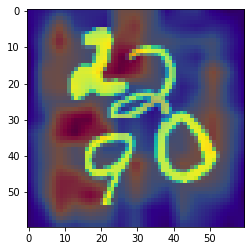

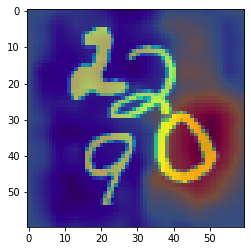

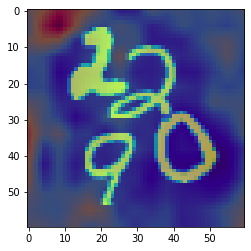

In [24]:
import torch.nn.functional as F
model.eval()
with torch.no_grad():
  _, out, _ = trainer.model(data[0].cuda().float())
  for i in range(3):
    activation_map = cam(i, out)
    activation_map = F.interpolate(activation_map.unsqueeze(0).unsqueeze(0), (60,60), mode="bilinear", align_corners=True)
    plt.imshow(data[0][0,0])
    plt.imshow(activation_map[0,0].cpu().numpy(), alpha=0.3, cmap="jet")
    plt.show()

torch.Size([1, 15, 15, 1])


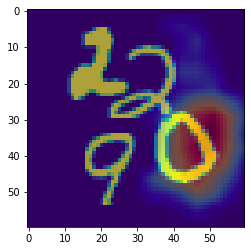

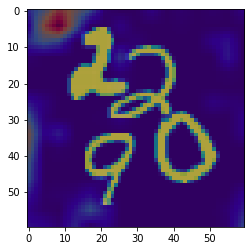

In [39]:
model.eval()

features, out, _ = trainer.model(data[0].cuda().float())
activation_map = compute_cam(features, out, 3)
print(activation_map[:,:,:,:1].shape)
for i in range(2):
  a_map = F.interpolate(activation_map[:,:,:,i].unsqueeze(0), (60,60), mode="bilinear", align_corners=True)
  plt.imshow(data[0][0,0])
  plt.imshow(a_map[0,0].detach().cpu().numpy(), alpha=0.3, cmap="jet")
  plt.show()

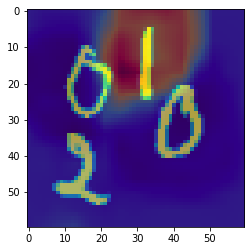

In [154]:
out

tensor([[ 8.1517, -7.3739, 11.7504]], device='cuda:0')

In [15]:
with torch.no_grad():
  out,_ = pseudoseg(torch.ones((1, 1, 60, 60)))
  a = cam(0,out)

In [16]:
a.shape#, out.shape

torch.Size([15, 15])

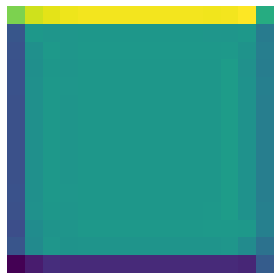

In [17]:
plt.imshow(a.numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [ ]:
def find_results(current_path, filename):
  if filename in os.listdir(current_path):
            x = open(os.path.join(current_path, 
                                  filename)).readlines()
            print(current_path)
            for l in x[-12:-8]:
              print(l)
            print()
            print()

base_path = "experiments/2-2"
for n_train in os.listdir(base_path):
  for batch_size in os.listdir(os.path.join(base_path, n_train)):
    for epoch in os.listdir(os.path.join(base_path, n_train, batch_size)):
      for method in os.listdir(os.path.join(base_path, n_train, batch_size, epoch)):
        for lambda_distillation in os.listdir(os.path.join(base_path, n_train, batch_size, epoch, method)):
          current_path = os.path.join(base_path, 
                                      n_train,
                                      batch_size, 
                                      epoch, 
                                      method, 
                                      lambda_distillation)
          find_results(current_path, "training_process.txt") # no distillation
          if lambda_distillation != '0' :
            for encoder_level_distillation in os.listdir(current_path):
              current_path = os.path.join(current_path, encoder_level_distillation)
              for decoder_level_distillation in os.listdir(current_path):
                current_path = os.path.join(current_path, decoder_level_distillation)
                for output_level_distillation in os.listdir(current_path):
                  current_path = os.path.join(current_path, output_level_distillation)
                  find_results(current_path, "training_process.txt") # with distillation
          
          
        

experiments/2-2/1000/72/200/mib/1/False/False/True
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:|-----------:|

|  0 |      0.958789 |   0.763774 |   0.645446 |



experiments/2-2/1000/72/200/mib/10/False/False/True
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:|-----------:|

|  0 |      0.957931 |   0.822508 |   0.655222 |



experiments/2-2/1000/72/200/mib/100/False/False/True
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:|-----------:|

|  0 |      0.906244 |   0.486729 |   0.331924 |



experiments/2-2/1000/72/200/mib/0
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:|-----------:|

|  0 |      0.895888 |   0.246483 |   0.197438 |



experiments/2-2/1000/72/200/pseudo_label/0
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:

#Experiments for Fine-tuning model (naive approach)

In [ ]:
# Initialize dataloader, optimizer and trainer

model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=5000, n_test=2500, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer(model,
                  n_classes=[3],
                  optim=optimizer,
                  callbacks=[evaluater])


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 100,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           memory=None,
           animation_path='naive')

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 100/100 [01:35<00:00,  1.04it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.991925 |   0.942679 |   0.893262 |
Class IoU
|    |       -1 |        0 |       1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.991616 | 0.848289 | 0.83988 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |       0 |       1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|--------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.995617 | 0.92524 | 0.90718 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 100/100 [01:49<00:00,  1.09s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.962181 |   0.563367 |   0.521989 |
Class IoU
|    |       -1 |   0 |   1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.961514 |   0 |   0 | 0.816029 | 0.832403 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |     -1 |   0 |   1 |       2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|-------:|----:|----:|--------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.9967 |   0 |   0 | 0.91157 | 0.908566 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.938506 |   0.398659 |   0.363912 |
Class IoU
|    |       -1 |   0 |   1 |   2 |   3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.937676 |   0 |   0 |   0 |   0 | 0.806767 | 0.802941 | X   | X   | X   | X   |
Class Acc
|    |       -1 |   0 |   1 |   2 |   3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.997556 |   0 |   0 |   0 |   0 | 0.909349 | 0.883711 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.920117 |   0.314419 |   0.279451 |
Class IoU
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |        6 |        7 | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|----:|----:|---------:|---------:|:----|:----|
|  0 | 0.920111 |   0 |   0 |   0 |   0 |   0 |   0 | 0.828025 | 0.766919 | X   | X   |
Class Acc
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |      6 |        7 | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|----:|----:|-------:|---------:|:----|:----|
|  0 | 0.998165 |   0 |   0 |   0 |   0 |   0 |   0 | 0.9093 | 0.922308 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes to learn:
-1 8 9
*******


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.89698 |   0.255952 |   0.227844 |
Class IoU
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |        8 |        9 |
|---:|---------:|----:|----:|----:|----:|----:|----:|----:|----:|---------:|---------:|
|  0 | 0.896159 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 | 0.805637 | 0.804489 |
Class Acc
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |        8 |        9 |
|---:|---------:|----:|----:|----:|----:|----:|----:|----:|----:|---------:|---------:|
|  0 | 0.998263 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 | 0.916734 | 0.900476 |


#Distillation
##Output-level distillation loss

In [ ]:
model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=5000, n_test=1000, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer_distillation(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  lambda_distill=10,
                  output_level_distill=True,
                  callbacks=[evaluater])


In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="output_level_distillation_ntrain5000_epochs200")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [02:47<00:00,  1.19it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.994078 |   0.945941 |   0.914837 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.993843 | 0.884215 | 0.866452 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.997575 | 0.927281 | 0.912968 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [05:18<00:00,  1.59s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.988196 |   0.953901 |   0.857909 |
Class IoU
|    |       -1 |       0 |      1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|-------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.988523 | 0.84873 | 0.8058 | 0.826181 | 0.820309 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.991212 | 0.975785 | 0.949027 | 0.925399 | 0.928083 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [05:21<00:00,  1.61s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.977607 |   0.941434 |   0.780645 |
Class IoU
|    |       -1 |       0 |        1 |        2 |        3 |        4 |       5 | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|---------:|---------:|---------:|---------:|--------:|:----|:----|:----|:----|
|  0 | 0.978962 | 0.74915 | 0.676023 | 0.727604 | 0.778002 | 0.802756 | 0.75202 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |       1 |        2 |        3 |       4 |       5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|--------:|---------:|---------:|--------:|--------:|:----|:----|:----|:----|
|  0 | 0.981293 | 0.980176 | 0.95558 | 0.936812 | 0.924356 | 0.90131 | 0.91051 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [05:59<00:00,  1.80s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.960762 |   0.931709 |   0.706883 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.963543 | 0.647261 | 0.518086 | 0.629075 | 0.632562 | 0.773288 | 0.695142 | 0.774186 | 0.728803 | X   | X   |
Class Acc
|    |       -1 |        0 |       1 |       2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|--------:|--------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.964288 | 0.971504 | 0.91965 | 0.88314 | 0.947523 | 0.922411 | 0.935183 | 0.907143 | 0.934538 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes

100%|██████████| 200/200 [06:18<00:00,  1.89s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.945159 |     0.9124 |    0.67882 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |       4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.950082 | 0.580728 | 0.363543 | 0.598795 | 0.583828 | 0.75816 | 0.683316 | 0.777141 | 0.738784 | 0.700728 | 0.731909 |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.950321 | 0.966066 | 0.916938 | 0.876796 | 0.936702 | 0.893237 | 0.922812 | 0.878904 | 0.938222 | 0.900747 | 0.855656 |


# MiB

In [ ]:
# Initialize dataloader, optimizer and trainer
model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=5000, n_test=1000, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer_MIB(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  lambda_distill=10,
                  output_level_distill=True,
                  callbacks=[evaluater])

In [ ]:
#Note : pour sauvegarder les prints dans un fichier
#import contextlib
 
#file_path = 'randomfile.txt'
#with open(file_path, "w") as o:
#    with contextlib.redirect_stdout(o):
#         ...

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="MIB_lambda10_ntrain1000_epochs200")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [02:50<00:00,  1.17it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.992954 |   0.957715 |   0.905226 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.992731 | 0.861754 | 0.861193 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.995384 | 0.955269 | 0.922492 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [05:27<00:00,  1.64s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.989084 |   0.918544 |   0.868001 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.989244 | 0.868994 | 0.862793 | 0.791798 | 0.827174 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.995305 | 0.953208 | 0.897508 | 0.865699 | 0.880998 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [05:44<00:00,  1.72s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.98575 |   0.908998 |    0.84377 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.986728 | 0.867528 | 0.863911 | 0.778685 | 0.804365 | 0.792522 | 0.812651 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.993917 | 0.946519 | 0.925926 | 0.850529 | 0.876265 | 0.874665 | 0.895164 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [06:28<00:00,  1.94s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.983598 |   0.907625 |   0.829804 |
Class IoU
|    |       -1 |        0 |       1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.987308 | 0.865156 | 0.86607 | 0.788392 | 0.794024 | 0.796452 | 0.790051 | 0.813186 | 0.767593 | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.993341 | 0.939739 | 0.925791 | 0.867896 | 0.889704 | 0.894198 | 0.881324 | 0.903202 | 0.873434 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Clas

100%|██████████| 200/200 [06:26<00:00,  1.93s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.980743 |    0.89543 |   0.815073 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |       5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|
|  0 | 0.988007 | 0.861833 | 0.851327 | 0.745962 | 0.790688 | 0.780746 | 0.77715 | 0.798396 | 0.742697 | 0.837762 | 0.791239 |
Class Acc
|    |       -1 |        0 |        1 |        2 |       3 |        4 |        5 |        6 |        7 |        8 |       9 |
|---:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|--------:|
|  0 | 0.994378 | 0.931205 | 0.913872 | 0.835039 | 0.88267 | 0.889123 | 0.848157 | 0.867385 | 0.887881 | 0.911866 | 0.88816 |


#Pseudo-labeling

In [ ]:
from trainer import Trainer_PseudoLabel
# Initialize dataloader, optimizer and trainer
model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=5000, n_test=1000, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer_PseudoLabel(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  callbacks=[evaluater])

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [02:53<00:00,  1.15it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.993927 |   0.954471 |   0.913444 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.993751 | 0.875523 | 0.871059 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |       0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.996816 | 0.93469 | 0.931908 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [03:30<00:00,  1.05s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.988858 |   0.931454 |   0.862699 |
Class IoU
|    |       -1 |        0 |        1 |       2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|--------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.989286 | 0.848544 | 0.831308 | 0.81621 | 0.828147 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.994205 | 0.934559 | 0.933601 | 0.880257 | 0.914647 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [03:43<00:00,  1.12s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.985626 |   0.922481 |   0.837539 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.987602 | 0.859625 | 0.846159 | 0.759538 | 0.801912 | 0.808048 | 0.799887 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.992301 | 0.943839 | 0.917378 | 0.882223 | 0.889399 | 0.932723 | 0.899504 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [04:06<00:00,  1.23s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.982987 |   0.904757 |    0.81766 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.988369 | 0.850946 | 0.850677 | 0.743132 | 0.767267 | 0.783382 | 0.749467 | 0.826275 | 0.799428 | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |       2 |        3 |       4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|--------:|---------:|--------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.993105 | 0.917172 | 0.892547 | 0.84064 | 0.893285 | 0.90794 | 0.854743 | 0.917782 | 0.925598 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes

100%|██████████| 200/200 [03:58<00:00,  1.19s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.97991 |   0.878932 |   0.801369 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.988914 | 0.847721 | 0.829932 | 0.715232 | 0.724035 | 0.784908 | 0.729348 | 0.813106 | 0.802341 | 0.785321 | 0.794208 |
Class Acc
|    |      -1 |        0 |        1 |        2 |        3 |        4 |       5 |       6 |        7 |        8 |        9 |
|---:|--------:|---------:|---------:|---------:|---------:|---------:|--------:|--------:|---------:|---------:|---------:|
|  0 | 0.99604 | 0.903243 | 0.863118 | 0.776772 | 0.841284 | 0.875354 | 0.85269 | 0.89101 | 0.873799 | 0.897905 | 0.897034 |


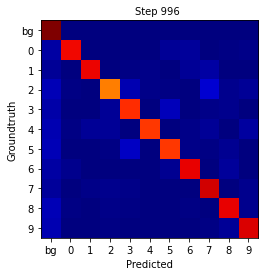

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="pseudolabel")

# Pseudo labeling with image level labels

In [ ]:
from trainer import Trainer_PseudoLabel_ImageLabels
# Initialize dataloader, optimizer and trainer
model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=500, n_test=1000, batch_size=72, tasks=_tasks, return_im_level_label=True)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer_PseudoLabel_ImageLabels(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  callbacks=[evaluater])

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [02:47<00:00,  1.19it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.993305 |   0.948355 |   0.912075 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.993059 | 0.872139 | 0.871029 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.997014 | 0.920222 | 0.927828 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [03:36<00:00,  1.08s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.989874 |   0.939977 |   0.875091 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.990693 | 0.863008 | 0.865029 | 0.812005 | 0.844719 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.994452 | 0.916055 | 0.922337 | 0.930589 | 0.936454 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [03:42<00:00,  1.11s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.986874 |   0.912531 |   0.844126 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |      5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|-------:|:----|:----|:----|:----|
|  0 | 0.989128 | 0.854741 | 0.855673 | 0.795687 | 0.795788 | 0.847766 | 0.7701 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |       4 |       5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|--------:|--------:|:----|:----|:----|:----|
|  0 | 0.994742 | 0.906875 | 0.901091 | 0.881424 | 0.856417 | 0.93364 | 0.91353 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [04:05<00:00,  1.23s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.984868 |   0.897309 |   0.838278 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.988422 | 0.850638 | 0.835078 | 0.790828 | 0.808233 | 0.827193 | 0.791515 | 0.819522 | 0.833069 | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.996113 | 0.889497 | 0.870263 | 0.842463 | 0.872885 | 0.894372 | 0.858748 | 0.930416 | 0.921028 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
C

100%|██████████| 200/200 [04:11<00:00,  1.26s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.980159 |   0.887329 |   0.816553 |
Class IoU
|    |       -1 |        0 |        1 |       2 |        3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.986252 | 0.831943 | 0.841151 | 0.75966 | 0.782031 | 0.812736 | 0.750604 | 0.809043 | 0.776995 | 0.812007 | 0.819665 |
Class Acc
|    |      -1 |        0 |        1 |        2 |        3 |       4 |       5 |        6 |        7 |        8 |        9 |
|---:|--------:|---------:|---------:|---------:|---------:|--------:|--------:|---------:|---------:|---------:|---------:|
|  0 | 0.99486 | 0.893494 | 0.872093 | 0.825443 | 0.826489 | 0.88283 | 0.83638 | 0.911452 | 0.850047 | 0.939605 | 0.927925 |


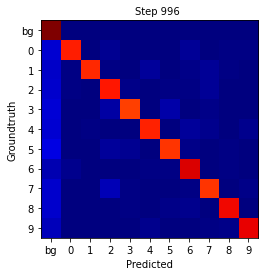

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="pseudolabel_image_level")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [00:31<00:00,  6.43it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.98144 |   0.796604 |   0.746056 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.981471 | 0.666662 | 0.590034 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |       1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.994261 | 0.780013 | 0.61554 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [00:44<00:00,  4.49it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.969341 |   0.734501 |   0.642969 |
Class IoU
|    |     -1 |        0 |        1 |       2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|-------:|---------:|---------:|--------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.9726 | 0.653263 | 0.547046 | 0.48571 | 0.556226 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |      -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|--------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.98945 | 0.716875 | 0.567807 | 0.638934 | 0.759438 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [00:49<00:00,  4.06it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.956511 |   0.662104 |   0.536135 |
Class IoU
|    |      -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.96871 | 0.621754 | 0.569557 | 0.316852 | 0.309039 | 0.558071 | 0.408962 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |       3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.986933 | 0.737079 | 0.598872 | 0.456672 | 0.37727 | 0.739926 | 0.737975 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [00:55<00:00,  3.61it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.926037 |   0.500402 |   0.355742 |
Class IoU
|    |       -1 |        0 |        1 |           2 |          3 |        4 |   5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|------------:|-----------:|---------:|----:|---------:|---------:|:----|:----|
|  0 | 0.964415 | 0.206539 | 0.565108 | 0.000575942 | 0.00555976 | 0.477474 |   0 | 0.522046 | 0.459962 | X   | X   |
Class Acc
|    |       -1 |        0 |       1 |           2 |          3 |       4 |   5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|--------:|------------:|-----------:|--------:|----:|---------:|---------:|:----|:----|
|  0 | 0.978217 | 0.762192 | 0.61858 | 0.000576191 | 0.00557491 | 0.58601 |   0 | 0.821005 | 0.731461 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes

100%|██████████| 200/200 [00:56<00:00,  3.56it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.927229 |    0.50966 |     0.3825 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |   5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|----:|---------:|---------:|---------:|---------:|
|  0 | 0.962722 | 0.452705 | 0.530584 | 0.121542 | 0.206754 | 0.260163 |   0 | 0.345205 | 0.391559 | 0.486451 | 0.449817 |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |   5 |        6 |      7 |        8 |       9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|----:|---------:|-------:|---------:|--------:|
|  0 | 0.990803 | 0.631683 | 0.569749 | 0.151435 | 0.276962 | 0.299366 |   0 | 0.486841 | 0.6109 | 0.825935 | 0.76259 |


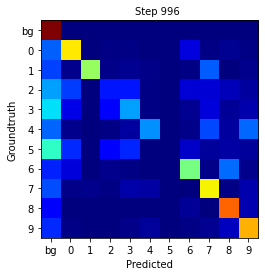

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="pseudolabel_image_level")

In [ ]:
np.array(continual_mnist.train_data.curr_im_level_labels)

array([[1, 1, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0]])

In [ ]:
len(a)

72

#Experiments with Memory model

In [ ]:
from models.memory import memory

In [ ]:
from models import simple_seg_model
# Initialize dataloader, optimizer and trainer
_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
_offline = {0: list(np.arange(10))}

model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

#continual_mnist = ContinualMnist(n_train=1000, n_test=500, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["acc", "iou", "confusion_matrix"], callback_frequency="step", n_classes=11, save_matrices=True)

mem = memory(images_shape=(1,60,60),
             masks_shape=(60,60),
             n_classes = 2,
             batch_size=72,
             memory_size=1000)

trainer = Trainer(model,
                  n_classes=[3],
                  optim=optimizer,
                  callbacks=[evaluater])

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           memory=mem,
           animation_path="memory_100e_72b_72bm")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [03:13<00:00,  1.04it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.894772 |   0.245599 |   0.212156 |
Class IoU
|    |      -1 |        0 |        1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|--------:|---------:|---------:|----:|----:|----:|----:|----:|----:|----:|----:|
|  0 | 0.89533 | 0.731385 | 0.706998 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Class Acc
|    |       -1 |        0 |        1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|---------:|---------:|---------:|----:|----:|----:|----:|----:|----:|----:|----:|
|  0 | 0.998337 | 0.888966 | 0.814283 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [03:48<00:00,  1.14s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.904283 |   0.294001 |   0.275561 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|---------:|---------:|---------:|---------:|---------:|----:|----:|----:|----:|----:|----:|
|  0 | 0.903418 | 0.663515 | 0.547239 | 0.432992 | 0.484005 |   0 |   0 |   0 |   0 |   0 |   0 |
Class Acc
|    |       -1 |        0 |        1 |       2 |        3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|---------:|---------:|---------:|--------:|---------:|----:|----:|----:|----:|----:|----:|
|  0 | 0.999185 | 0.686422 | 0.564824 | 0.46302 | 0.520563 |   0 |   0 |   0 |   0 |   0 |   0 |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [03:51<00:00,  1.16s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.903197 |   0.302314 |   0.270565 |
Class IoU
|    |      -1 |        0 |        1 |        2 |        3 |      4 |        5 |   6 |   7 |   8 |   9 |
|---:|--------:|---------:|---------:|---------:|---------:|-------:|---------:|----:|----:|----:|----:|
|  0 | 0.90572 | 0.410376 | 0.140271 | 0.276468 | 0.180908 | 0.5391 | 0.523378 |   0 |   0 |   0 |   0 |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |       4 |        5 |   6 |   7 |   8 |   9 |
|---:|---------:|---------:|---------:|---------:|---------:|--------:|---------:|----:|----:|----:|----:|
|  0 | 0.998396 | 0.413438 | 0.140731 | 0.315535 | 0.192333 | 0.59892 | 0.666106 |   0 |   0 |   0 |   0 |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [03:58<00:00,  1.19s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.89475 |   0.226963 |   0.204347 |
Class IoU
|    |       -1 |         0 |         1 |          2 |         3 |           4 |         5 |        6 |        7 |   8 |   9 |
|---:|---------:|----------:|----------:|-----------:|----------:|------------:|----------:|---------:|---------:|----:|----:|
|  0 | 0.895059 | 0.0583491 | 0.0037377 | 0.00485458 | 0.0448504 | 0.000892061 | 0.0727346 | 0.617062 | 0.550281 |   0 |   0 |
Class Acc
|    |      -1 |         0 |          1 |          2 |         3 |           4 |         5 |        6 |        7 |   8 |   9 |
|---:|--------:|----------:|-----------:|-----------:|----------:|------------:|----------:|---------:|---------:|----:|----:|
|  0 | 0.99906 | 0.0584551 | 0.00373795 | 0.00486978 | 0.0449805 | 0.000892061 | 0.0740401 | 0.707892 | 0.602661 |   0 |   0 |

####################################
Next Task
########

100%|██████████| 200/200 [04:02<00:00,  1.21s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.889065 |   0.185208 |   0.167559 |
Class IoU
|    |       -1 |          0 |           1 |   2 |   3 |   4 |   5 |          6 |   7 |       8 |        9 |
|---:|---------:|-----------:|------------:|----:|----:|----:|----:|-----------:|----:|--------:|---------:|
|  0 | 0.889022 | 0.00339271 | 0.000131156 |   0 |   0 |   0 |   0 | 0.00116352 |   0 | 0.48455 | 0.464889 |
Class Acc
|    |       -1 |          0 |           1 |   2 |   3 |   4 |   5 |          6 |   7 |        8 |        9 |
|---:|---------:|-----------:|------------:|----:|----:|----:|----:|-----------:|----:|---------:|---------:|
|  0 | 0.999227 | 0.00340215 | 0.000131156 |   0 |   0 |   0 |   0 | 0.00116361 |   0 | 0.534506 | 0.498853 |

####################################
Next Task
####################################


## Intermediate-level + out distillation

In [ ]:
from trainer import Trainer_distillation
from models import simple_seg_model
_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
_offline = {0: list(np.arange(10))}

model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=1000, n_test=500, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["acc", "iou", "confusion_matrix"], callback_frequency="step", n_classes=11, save_matrices=True)

trainer = Trainer_distillation(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  lambda_distill=10,
                  output_level_distill=True,
                  encoder_level_distill=True,
                  callbacks=[evaluater])

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="distillation_intermediate")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [01:55<00:00,  1.73it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.988017 |   0.900923 |   0.841821 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.987756 | 0.785254 | 0.752453 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |       1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.994692 | 0.866687 | 0.84139 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [02:53<00:00,  1.15it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.970977 |   0.877968 |   0.702618 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.973779 | 0.744079 | 0.611172 | 0.567803 | 0.616258 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.980218 | 0.922697 | 0.915696 | 0.772303 | 0.798925 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.935503 |   0.808642 |   0.519026 |
Class IoU
|    |       -1 |       0 |        1 |        2 |       3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|---------:|---------:|--------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.945914 | 0.62079 | 0.451053 | 0.422709 | 0.40278 | 0.436113 | 0.353825 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.949047 | 0.926183 | 0.887534 | 0.715054 | 0.736735 | 0.797086 | 0.648855 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [03:28<00:00,  1.04s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.90356 |   0.760509 |    0.44988 |
Class IoU
|    |       -1 |       0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.920647 | 0.51977 | 0.366764 | 0.357445 | 0.296221 | 0.392499 | 0.301857 | 0.466215 | 0.427498 | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |       2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.921527 | 0.908652 | 0.827248 | 0.65136 | 0.723426 | 0.652097 | 0.649786 | 0.767645 | 0.742845 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes

100%|██████████| 200/200 [03:34<00:00,  1.07s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.872544 |   0.672709 |   0.384537 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.903896 | 0.404296 | 0.249562 | 0.311565 | 0.246773 | 0.368496 | 0.263955 | 0.433936 | 0.430866 | 0.282451 | 0.334106 |
Class Acc
|    |       -1 |        0 |        1 |        2 |       3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.904136 | 0.904821 | 0.843158 | 0.577177 | 0.57341 | 0.581793 | 0.545429 | 0.634699 | 0.680189 | 0.585898 | 0.569094 |

####################################
Next Task
#####

## Intermediate-level + decoder-level + output distillation

In [ ]:
from trainer import Trainer_distillation
from models import simple_seg_model
_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
_offline = {0: list(np.arange(10))}

model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=1000, n_test=72*2, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["acc", "iou", "confusion_matrix"], callback_frequency="step", n_classes=11, save_matrices=True)

trainer = Trainer_distillation(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  lambda_distill=1.25,
                  output_level_distill=True,
                  encoder_level_distill=False,
                  decoder_level_distill=True,
                  callbacks=[evaluater])

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="distillation_encoder_decoder_output")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [00:49<00:00,  4.01it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.985297 |   0.839015 |    0.80395 |
Class IoU
|    |      -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|--------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.98483 | 0.704047 | 0.722973 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.996656 | 0.755472 | 0.764916 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [01:30<00:00,  2.21it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.962843 |   0.578546 |   0.539237 |
Class IoU
|    |       -1 |        0 |        1 |        2 |       3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.963308 | 0.409522 | 0.335609 | 0.470765 | 0.51698 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |       3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.995584 | 0.419876 | 0.337916 | 0.530095 | 0.60926 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [01:40<00:00,  1.99it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.938827 |   0.381739 |   0.301692 |
Class IoU
|    |       -1 |        0 |        1 |          2 |          3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|-----------:|-----------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.946514 | 0.126115 | 0.110989 | 0.00724871 | 0.00320602 | 0.532312 | 0.385459 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |          2 |          3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|-----------:|-----------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.994572 | 0.127473 | 0.111081 | 0.00726158 | 0.00320736 | 0.747604 | 0.680975 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.92779 |   0.389293 |   0.321474 |
Class IoU
|    |       -1 |        0 |         1 |   2 |   3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|----------:|----:|----:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.935002 | 0.118656 | 0.0816383 |   0 |   0 | 0.316998 | 0.286344 | 0.631016 | 0.523607 | X   | X   |
Class Acc
|    |       -1 |        0 |         1 |   2 |   3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|----------:|----:|----:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.994709 | 0.119045 | 0.0816607 |   0 |   0 | 0.336829 | 0.390513 | 0.800251 | 0.780633 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes to learn:
-1 8 9
*******


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.899932 |   0.275167 |   0.234491 |
Class IoU
|    |       -1 |         0 |          1 |   2 |   3 |         4 |         5 |        6 |        7 |       8 |        9 |
|---:|---------:|----------:|-----------:|----:|----:|----------:|----------:|---------:|---------:|--------:|---------:|
|  0 | 0.902696 | 0.0161027 | 0.00219962 |   0 |   0 | 0.0027115 | 0.0148982 | 0.251196 | 0.245983 | 0.58952 | 0.554093 |
Class Acc
|    |       -1 |         0 |          1 |   2 |   3 |          4 |         5 |        6 |        7 |       8 |        9 |
|---:|---------:|----------:|-----------:|----:|----:|-----------:|----------:|---------:|---------:|--------:|---------:|
|  0 | 0.997193 | 0.0161536 | 0.00219962 |   0 |   0 | 0.00271199 | 0.0150326 | 0.257586 | 0.259404 | 0.74646 | 0.730091 |

####################################
Next Task
###################################